In [1]:
import sys
import jax
import os
import time
import pickle
import genjax
import bayes3d as b
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("../")
from viz import *
from utils import *
from mcs_utils import *
from PIL import Image
from io import BytesIO
import bayes3d.transforms_3d as t3d
from jax.debug import print as jprint
from tqdm import tqdm
from dataclasses import dataclass
from genjax._src.core.pytree.utilities import *
from genjax.generative_functions.distributions import ExactDensity
from tensorflow_probability.substrates import jax as tfp
import jax.tree_util as jtu
from genjax._src.core.transforms.incremental import NoChange, UnknownChange, Diff
console = genjax.pretty()
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
# Loading and preprocessing all data and renderer
SCALE = 0.2
cam_pose = CAM_POSE_CV2
inverse_cam_pose = jnp.linalg.inv(CAM_POSE_CV2)
scene_name = 'passive_physics_validation_object_permanence_0001_02'
# with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/pickled_data/{scene_name}.pkl", 'rb') as file:
#     preprocessed_data = pickle.load(file)
observations = load_observations_npz(scene_name)
preprocessed_data = preprocess_mcs_physics_scene(observations, MIN_DIST_THRESH=0.6, scale=SCALE)
(gt_images, gt_images_bg, gt_images_obj, intrinsics),\
(gt_images_orig, gt_images_bg_orig, gt_images_obj_orig, intrinsics_orig),\
registered_objects, obj_pixels, is_gravity, poses = preprocessed_data

# get obj indices padded
all_obj_indices = [np.argwhere(gt_images_obj[i,...,2] != intrinsics.far) for i in range(gt_images.shape[0])]
max_rows = max(obj_indices.shape[0] for obj_indices in all_obj_indices)
def pad_array(array, max_rows):
    padding = ((0, max_rows - array.shape[0]), (0, 0))  # Pad rows, not columns
    return jnp.pad(array, padding, constant_values=-1)

padded_all_obj_indices = jnp.stack([pad_array(array, max_rows) for array in all_obj_indices])

In [52]:
observations = np.load("../{}.npz".format(77242958318),allow_pickle=True)["arr_0"]
SCALE =0.2
preprocessed_data = preprocess_mcs_physics_scene(observations, MIN_DIST_THRESH=0.6, scale=SCALE)
# with open(f"/home/arijitdasgupta/bayes3d/scripts/experiments/intphys/mcs/pickled_data/{scene_ID}.pkl", 'rb') as file:
#     preprocessed_data = pickle.load(file)

(gt_images, gt_images_bg, gt_images_obj, intrinsics),\
(gt_images_orig, gt_images_bg_orig, gt_images_obj_orig, intrinsics_orig),\
registered_objects, obj_pixels, is_gravity, poses, cam_pose = preprocessed_data

Extracting Meshes


  1%|          | 1/100 [00:00<00:10,  9.24it/s]

Adding new mesh for t = {} 0


 25%|██▌       | 25/100 [00:00<00:02, 25.23it/s]

Adding review
Review passed, added to init queue
Adding new mesh for t = {} 22
Adding review
Review passed, added to init queue
Adding new mesh for t = {} 23
Adding review


 31%|███       | 31/100 [00:01<00:02, 24.34it/s]

Review passed, added to init queue


100%|██████████| 100/100 [00:04<00:00, 23.17it/s]


Extracting downsampled data


In [33]:
registered_objects


[
    {
        't_init': 21,
        'pose': Array([[ 1.       ,  0.       ,  0.       , -1.3350611],
       [ 0.       ,  1.       ,  0.       , -2.914764 ],
       [ 0.       ,  0.       ,  1.       ,  7.8858347],
       [ 0.       ,  0.       ,  0.       ,  1.       ]], dtype=float32),
        'full_pose': Array([[ 1.       ,  0.       ,  0.       , -1.3347641],
       [ 0.       ,  1.       ,  0.       , -2.6503453],
       [ 0.       ,  0.       ,  1.       ,  7.8808002],
       [ 0.       ,  0.       ,  0.       ,  1.       ]], dtype=float32),
        't_full': 23,
        'num_pixels': 1494,
        'mesh': <trimesh.Trimesh(vertices.shape=(332, 3), faces.shape=(660, 3))>
    }
]

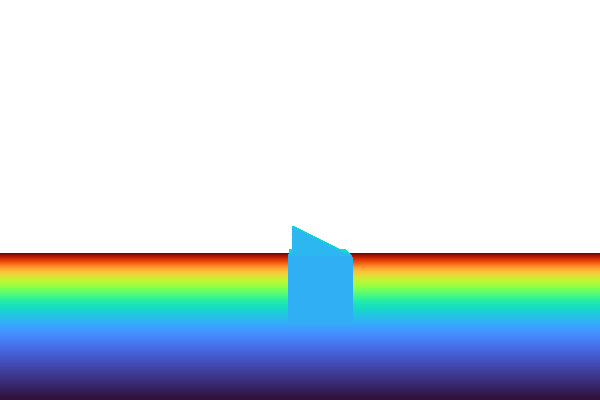

In [53]:
b.get_depth_image(gt_images_orig[-1,...,2])

In [ ]:
len(poses[0])

In [54]:
def gravity_scene_plausible(poses, gt_images_obj_orig, gt_images_bg_orig, intrinsics, registered_objects):

    # account for case where support is identified as an object
    max_poses_detected = 0
    for i in range(len(poses)):
        if len(poses[i]) > max_poses_detected:
            max_poses_detected = len(poses[i])
    new_poses = [[] for _ in range(len(poses))]
    if max_poses_detected > 2:
        support_pose = poses[0][0]
        for i in range(len(poses)):
            for j in range(len(poses[i])):
                diff = np.linalg.norm(support_pose[:3,3] - poses[i][j][:3,3])
                if diff > 0.01:
                    new_poses[i].append(poses[i][j])

        poses = new_poses

    idx = 0
    while len(poses[idx]) < 2:
        idx += 1
    while len(poses[idx]) > 1:
        idx += 1

    first_checkpt = idx

    while len(poses[idx]) < 2:
        diff = np.linalg.norm(poses[idx+1][0][:3,3] - poses[idx][0][:3,3])
        if diff == 0.0:
            break
        idx+=1

    second_checkpt = idx

    ref_pose = poses[idx][0]
    ref_depth_obj = gt_images_obj_orig[idx,...,2]
    ref_depth_bg = gt_images_bg_orig[idx,...,2]

    if max_poses_detected > 2:
        ref_depth_bg  = np.where(registered_objects[0]['mask'], ref_depth_obj, ref_depth_bg)
        ref_depth_obj = np.where(registered_objects[0]['mask'], intrinsics.far, ref_depth_obj)

    obj_indices = np.argwhere(ref_depth_obj != intrinsics.far)
    bottom_i = np.max(obj_indices[:,0])

    base_pixel_offset = 20
    base_depth_delta_thresh = 1
    line = ref_depth_bg[bottom_i+base_pixel_offset]
    base_j_min = None
    base_j_max = None
    on_support = False
    for j in range(len(line)-1):
        if not on_support and line[j+1] < line[j] - base_depth_delta_thresh:
            base_j_min = j
            on_support = True
        if on_support and line[j+1] > line[j] + base_depth_delta_thresh:
            base_j_max = j
            break
        if j == len(line) - 2:
            print("Error: There is no base for support")
            return True, [True for _ in range(len(poses))], 1e+20
        
    pixels_stable = np.sum(np.logical_and(obj_indices[:,1] <= base_j_max , obj_indices[:,1] >= base_j_min))
    pixels_unstable = np.sum(np.logical_or(obj_indices[:,1] > base_j_max , obj_indices[:,1] < base_j_min))
    stable = pixels_stable >= pixels_unstable
    ref_height = (cam_pose @ ref_pose)[2,3]
    end_height = (cam_pose @ poses[-1][0])[2,3]
    # fell = ref_height > end_height + 0.2
    fell = np.linalg.norm(ref_pose[:3,3] - poses[-1][0][:3,3]) > 0.1
    perc = 100*(np.abs(pixels_unstable - pixels_stable)/(pixels_stable+pixels_unstable))

    if perc < 5: # any outcome should be plausible
        return True, [True for _ in range(len(poses))], 1e+20

    t_violation = 1e+20
    if stable and fell:
        plausible = False
        t_violation = second_checkpt
    elif not stable and not fell:
        plausible = False
        t_violation = first_checkpt
    else:
        plausible = True

    plausibility_list = []
    for t in range(len(poses)):
        if t >= t_violation:
            plausibility_list.append(False)
        else:
            plausibility_list.append(True)

            
    return plausible, plausibility_list, t_violation

In [55]:
plausible, plausibility_list, _  = gravity_scene_plausible(poses, gt_images_obj_orig, gt_images_bg_orig, intrinsics_orig)

In [56]:
plausible

True

In [9]:
ref_depth_bg = gt_images_bg_orig[34,...,2]
ref_depth_obj = gt_images_obj_orig[34,...,2]

In [18]:
test  = np.where(registered_objects[0]['mask'], ref_depth_obj, ref_depth_bg)
test2 = np.where(registered_objects[0]['mask'], intrinsics.far, ref_depth_obj)

In [20]:
np.unique(test2[registered_objects[0]['mask']])

array([150.], dtype=float32)

In [ ]:
intrinsics

In [ ]:
b.setup_renderer(intrinsics, num_layers= 1024)
for i,registered_obj in enumerate(registered_objects):
    b.RENDERER.add_mesh(registered_obj['mesh'])
    # f_p = registered_objects[i]["full_pose"]
    # registered_objects[i]["full_pose"] = f_p.at[2,3].set(f_p[2,3] + 0.5*b.RENDERER.model_box_dims[i][2])
if len(registered_objects) == 0:
    t_start = gt_images.shape[0]-100
    registered_objects.append({'t_init' : gt_images.shape[0]-100,
                            'pose' : jnp.eye(4).at[:3,3].set([0,0,1e+5]),
                            'full_pose' : jnp.eye(4).at[:3,3].set([0,0,1e+5]),
                            't_full' : gt_images.shape[0]-100})
    b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/cube.obj"), scaling_factor = 0.1)
else:
    t_start = np.min([x["t_full"] for x in registered_objects])
# video_from_rendered(gt_images, scale = int(1/SCALE), framerate=30)

In [ ]:
# model time!

def get_height_bounds(i, world_pose):
    # Half dimensions to get the corner points relative to the center
    rotation_matrix = world_pose[:3,:3]
    center = world_pose[:3,3]
    dimensions = b.RENDERER.model_box_dims[i]
    half_dims = dimensions / 2

    # Local corner points of the box in its local coordinate system
    local_corners = jnp.array([
        [-half_dims[0], -half_dims[1], -half_dims[2]],  # Lower rear left corner
        [ half_dims[0], -half_dims[1], -half_dims[2]],  # Lower rear right corner
        [-half_dims[0],  half_dims[1], -half_dims[2]],  # Lower front left corner
        [ half_dims[0],  half_dims[1], -half_dims[2]],  # Lower front right corner
        [-half_dims[0], -half_dims[1],  half_dims[2]],  # Upper rear left corner
        [ half_dims[0], -half_dims[1],  half_dims[2]],  # Upper rear right corner
        [-half_dims[0],  half_dims[1],  half_dims[2]],  # Upper front left corner
        [ half_dims[0],  half_dims[1],  half_dims[2]]   # Upper front right corner
    ])

    # Apply rotation to each corner point
    global_corners = jnp.stack([center + rotation_matrix @ corner for corner in local_corners])

    # Find the bottom-most point
    bottom_most_point_z = jnp.min(global_corners[:,2])
    top_most_point_z = jnp.max(global_corners[:,2])
    # distance from centre of bbox to bottom of bbox
    center_to_bottom_dist = center[2] - bottom_most_point_z
    return bottom_most_point_z,top_most_point_z, center_to_bottom_dist

def get_translation_direction(all_poses, t_full, t):
    direction = all_poses[t-1][:3,3] - all_poses[t_full+1][:3,3]
    direction = cam_pose[:3,:3] @ direction
    direction_xy = direction.at[2].set(0)

    normalized_direction_xy = jax.lax.cond(jnp.equal(jnp.linalg.norm(direction_xy), 0),
                                         lambda: direction_xy,
                                         lambda: direction_xy/jnp.linalg.norm(direction_xy))
    return normalized_direction_xy


# This model has to be recompiled for different # objects for now this is okay
@genjax.gen
def physics_stepper(all_poses, t, t_full, i, friction, gravity):
    # TODO: SAMPLING FRICTION SCHEME --> can be of a hmm style

    #################################################################
    # First let us consider timestep t-1
    #################################################################
    # Step 2: find world pose
    pose_prev = all_poses[t-1]
    pose_prev_world = cam_pose @ pose_prev

    # Step 3: check if we are already on the floor
    bottom_z, top_z, center_to_bottom = get_height_bounds(i, pose_prev_world)
    # within 20% of the object's height in world frame
    already_on_floor = jnp.less_equal(bottom_z,0.2 * (top_z - bottom_z))
    
    # Step 1: Find world velocity
    vel_pose_camera = jnp.linalg.solve(all_poses[t-2], all_poses[t-1])
    pre_vel_xyz_world = cam_pose[:3,:3] @ vel_pose_camera[:3,3]
    mag_xy = jnp.linalg.norm(pre_vel_xyz_world[:2])
    
    mag_xy_friction = mag_xy - friction * mag_xy

    # mag_xy_friction = jax.lax.cond(
    #     jnp.less_equal(jnp.abs(mag_xy_friction),3e-3),
    #     lambda:0.0,
    #     lambda:mag_xy_friction)
    
    mag_xy, gravity = jax.lax.cond(already_on_floor,lambda:(mag_xy_friction,gravity),lambda:(mag_xy, gravity))

    dir_xy_world = get_translation_direction(all_poses, t_full, t)

    # Step 7: Determine mag and gravity

    vel_xyz_world = mag_xy * dir_xy_world
    # Step 6: apply z axis change
    vel_xyz_world = vel_xyz_world.at[2].set(pre_vel_xyz_world[2] - gravity * 1./20)

    # Step 5: find peturbed velocity (equal to original norm) with random rotation
    perturbed_rot_pose = GaussianVMFPoseUntraced()(jnp.eye(4), *(1e-20, 10000.0))  @ "perturb"

    vel_xyz_world_perturbed = perturbed_rot_pose[:3,:3] @ vel_xyz_world # without friction

    vel_xyz_camera = inverse_cam_pose[:3,:3] @ vel_xyz_world_perturbed

    # Step 8: Get velocity update in camera frame
    vel = pose_prev.at[:3,3].set(vel_xyz_camera)

    # Step 9: Identify next pose
    next_pose = pose_prev.at[:3,3].set(pose_prev[:3,3] + vel[:3,3]) # trans only, no rot

    # Step 10: Ensure new bottom of object is above floor --> ground collision
    next_pose_world = cam_pose @ next_pose
    bottom_z,_,center_to_bottom = get_height_bounds(i, next_pose_world)
    next_pose = jax.lax.cond(
        jnp.less_equal(bottom_z,0),
        lambda:inverse_cam_pose @ next_pose_world.at[2,3].set(center_to_bottom),
        lambda:next_pose
    )

    return next_pose

def threedp3_likelihood_arijit(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
):
    distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
    probabilities_per_pixel = (distances < variance/2) / variance
    average_probability = 1 * probabilities_per_pixel.mean()
    return average_probability

threedp3_likelihood_arijit_vmap = jax.vmap(threedp3_likelihood_arijit, in_axes=(None,0,None,None))
threedp3_likelihood_arijit_double_vmap = jax.vmap(threedp3_likelihood_arijit, in_axes=(0,0,None,None))

def outlier_gaussian(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
):
    distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
    probabilities_per_pixel = jax.scipy.stats.norm.pdf(
        distances,
        loc=0.0, 
        scale=variance
    )
    average_probability = 0.01 * probabilities_per_pixel.sum()
    return average_probability

outlier_gaussian_double_vmap = jax.vmap(outlier_gaussian, in_axes=(0,0,None,None))
outlier_gaussian_vmap = jax.vmap(outlier_gaussian, in_axes=(None,0,None,None))

def outlier_gaussian_per_pixel(
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
):
    distances = jnp.linalg.norm(observed_xyz - rendered_xyz, axis=-1)
    probabilities_per_pixel = jax.scipy.stats.norm.pdf(
        distances,
        loc=0.0, 
        scale=variance
    )
    return 0.01 * probabilities_per_pixel

outlier_gaussian_per_pixel_vmap = jax.vmap(outlier_gaussian_per_pixel, in_axes=(None,0,None,None))

@dataclass
class ImageLikelihoodArijit(ExactDensity):
    def sample(self, key, img, variance, outlier_prob):
        return img

    def logpdf(self, observed_image, latent_image, variance, outlier_prob):
        # return threedp3_likelihood_arijit(
        #     observed_image, latent_image, variance, outlier_prob,
        # )        
        return outlier_gaussian(
            observed_image, latent_image, variance, outlier_prob,
        )
    
@dataclass
class GaussianVMFPoseUntraced(ExactDensity):
    def sample(self, key, pose_mean, var, concentration, **kwargs):
        return b.distributions.gaussian_vmf(key, pose_mean, var, concentration)

    def logpdf(self, pose, pose_mean, var, concentration, **kwargs):
        return 0

@genjax.gen
def mcs_model(prev_state, t_inits, t_fulls, init_poses, full_poses, pose_update_params, variance, outlier_prob):
    """
    Single Object Model HMM
    """

    (_, _, poses, all_poses, friction, t, gravity) = prev_state

    # jprint("t = {}, f = {}",t, friction)
    num_objects = poses.shape[0]
    
    # for each object
    for i in range(num_objects):        

        poses = poses.at[i].set(jax.lax.cond(
            jnp.equal(t_fulls[i],t), # full pose at the correct time step
            lambda:full_poses[i], 
            lambda:poses[i]))
        
        poses = poses.at[i].set(jax.lax.cond(
            jnp.equal(t_inits[i],t), # init pose at the correct time step
            lambda:init_poses[i], 
            lambda:poses[i]))

        physics_prob = jnp.asarray(jax.lax.cond(jnp.greater_equal(t,t_fulls[i]+2),lambda:1,lambda:0), dtype=int)
        physics_pose = physics_stepper(all_poses[:,i,...], t, t_fulls[i], i, friction, gravity) @ f"physics_{i}"
        final_pose, update_params = jax.lax.cond(physics_prob, lambda:(physics_pose, pose_update_params), lambda:(poses[i], (jnp.array([1e20,1e20,1e20]), 0.)))
                
        updated_pose = b.gaussian_vmf_pose(final_pose, *update_params)  @ f"pose_{i}"
        poses = poses.at[i].set(updated_pose)
        
    all_poses = all_poses.at[t].set(poses)
    rendered_image_obj = b.RENDERER.render(
        poses, jnp.arange(num_objects))[...,:3]

    # NOTE: gt_images_bg is a global variable here as it consumes too much memory for the trace
    rendered_image = splice_image(rendered_image_obj, gt_images_bg[t])

    sampled_image = ImageLikelihoodArijit()(rendered_image, variance, outlier_prob) @ "depth"
    # sampled_image = b.old_image_likelihood(rendered_image, 0.1, 0.001,1000,None) @ "depth"

    return (rendered_image, rendered_image_obj, poses, all_poses, friction, t+1, gravity)

In [ ]:
def pose_update_v5(key, trace_, pose_grid, enumerator):
    num_splits = (pose_grid.shape[0] // 400) + 1
    all_weights = jnp.array([])
    for split_pose_grid in jnp.array_split(pose_grid, num_splits):
        weights = enumerator.enumerate_choices_get_scores(trace_, key, split_pose_grid)
        all_weights = jnp.hstack([all_weights, weights])
    sampled_idx = all_weights.argmax() # jax.random.categorical(key, weights)
    # jprint("weights = {}",all_weights)
    # jprint("weight mix:{}",jnp.unique(jnp.sort(all_weights), size = 10))
    # jprint("idx chosen = {}",sampled_idx)
    return *enumerator.update_choices_with_weight(
        trace_, key,
        pose_grid[sampled_idx]
    ), pose_grid[sampled_idx]


pose_update_v5_jit = jax.jit(pose_update_v5, static_argnames=("enumerator",))


def c2f_pose_update_v5(key, trace_, reference, gridding_schedule, enumerator, obj_id,):
    # for each object (TODO: gibbs sampling)
    for i in range(len(gridding_schedule)):
        updated_grid = jnp.einsum("ij,ajk->aik", reference, gridding_schedule[i])
        # Time to check valid poses that dont intersect with the floor
        valid = jnp.logical_not(are_bboxes_intersecting_many_jit(
                            (100,100,20),
                            b.RENDERER.model_box_dims[obj_id],
                            jnp.eye(4).at[:3,3].set([0,0,-10.1]),
                            jnp.einsum("ij,ajk->aik",cam_pose,updated_grid)
                            ))
        # if pose is not valid, use the reference pose
        valid_grid = jnp.where(valid[:,None,None], updated_grid, reference[None,...])
        weight, trace_, reference = pose_update_v5_jit(key, trace_, valid_grid, enumerator)
        # jprint("ref position is {}", reference[:3,3])

    return weight, trace_

c2f_pose_update_v5_vmap_jit = jax.jit(jax.vmap(c2f_pose_update_v5, in_axes=(0,0,None,None,None)),
                                    static_argnames=("enumerator", "obj_id"))

c2f_pose_update_v5_jit = jax.jit(c2f_pose_update_v5,static_argnames=("enumerator", "obj_id"))

def make_new_keys(key, N_keys):
    key, other_key = jax.random.split(key)
    new_keys = jax.random.split(other_key, N_keys)
    return key, new_keys

def update_choice_map_no_unfold(gt_depths, constant_choices, t):
    constant_choices['depth'] = gt_depths[t]
    return genjax.choice_map(
                constant_choices
            )

def argdiffs_modelv7(trace):
    """
    Argdiffs specific to mcs_single_obejct model with no unfold
    """
    args = trace.get_args()
    argdiffs = (
        jtu.tree_map(lambda v: Diff(v, UnknownChange), args[0]),
        *jtu.tree_map(lambda v: Diff(v, NoChange), args[1:]),
    )
    return argdiffs

def proposal_choice_map_no_unfold(addresses, args, chm_args):
    addr = addresses[0] # custom defined
    return genjax.choice_map({
                        addr: args[0]
            })

def resampling_priority_fn(particles, all_padded_idxs, t, outlier_variance=0.1):
    rendered = particles.get_retval()[0]
    padded_idxs = all_padded_idxs[t]
    max_rows, _ = padded_idxs.shape

    # Create a mask for valid indices (not padded)
    valid_mask = padded_idxs[:, 0] != -1  # Assuming -1 is the padding value

    # Use the mask to select valid indices, replace invalid indices with a default valid index (e.g., 0)
    valid_row_indices = jnp.where(valid_mask, padded_idxs[:, 0], 0)
    valid_col_indices = jnp.where(valid_mask, padded_idxs[:, 1], 0)

    # Gather rendered and ground truth values
    rendered_values_at_indices = rendered[:, valid_row_indices, valid_col_indices, 2]
    gt_values_at_indices = gt_images[t, valid_row_indices, valid_col_indices, 2]

    # Compute inliers, using the mask to ignore the contributions of invalid indices
    inliers = jnp.where(valid_mask, jnp.abs(rendered_values_at_indices - gt_values_at_indices[None, ...]) < outlier_variance, False)
    inliers_per_particle = jnp.sum(inliers, axis=1)

    log_probs = jnp.log(inliers_per_particle + 1e-9)  # Add a small constant to avoid log(0)

    eff_ss = ess(normalize_weights(log_probs))

    return eff_ss, log_probs

    

In [ ]:
def inference_approach_G2(model, gt, gridding_schedules, model_args, init_state, key, t_start, constant_choices, T, addr, n_particles):
    """
    Sequential Importance Sampling on the non-unfolded HMM model
    with 3D pose enumeration proposal

    WITH JUST ONE PARTICLE
    """
    
    num_objects = init_state[2].shape[0]

    def get_next_state(particle):
        return (None,None,*particle.get_retval()[2:])
    get_next_state_vmap = jax.vmap(get_next_state, in_axes = (0,))

    # sample friction
    key, friction_keys = make_new_keys(key, n_particles)
    # frictions = jax.vmap(genjax.normal.sample, in_axes = (0,None,None))(friction_keys,*friction_params)
    # frictions = jnp.linspace(-0.03,0.07,n_particles)
    qs = jnp.linspace(0.05,0.95,n_particles)
    frictions = tfp.distributions.Normal(0.02,0.05).quantile(qs)
    # frictions = frictions.at[n_particles-1].set(0.5)
    gravities = jnp.linspace(0.5,2,n_particles)
    # broadcast init_state to number of particles
    init_states = jax.vmap(lambda f,g:(*init_state[:4], f, init_state[4], g), in_axes=(0,0))(frictions, gravities)

    # define functions for SIS/SMC
    init_fn = jax.jit(jax.vmap(model.importance, in_axes=(0,None,0)))
    update_fn = jax.jit(model.update)
    proposal_fn = c2f_pose_update_v5_jit

    def smc_body(carry, t):
        # get new keys
        print("jit compiling")
        # initialize particle based on last time step
        jprint("t = {}",t)
        
        key, log_weights, states,  = carry
        key, importance_keys = make_new_keys(key, n_particles)
        key, resample_key = jax.random.split(key)
        key, proposal_key = jax.random.split(key)

        variance = jax.lax.cond(
            jnp.less_equal(t, model_args[1][0] + 2),
            lambda: 1 * model_args[5],
            lambda: model_args[5]
        )

        modified_model_args = (*model_args[:5], variance, *model_args[6:])

        full_args = jax.vmap(lambda x,y:(x, *y), in_axes=(0,None))(states, modified_model_args)

        importance_log_weights, particles = init_fn(importance_keys, update_choice_map_no_unfold(gt,constant_choices, t), full_args)

        # propose good poses based on proposal
        def proposer(carry, p):
            key, idx = carry
            proposal_log_weight = 0
            # argdiff and enumerator
            argdiffs = argdiffs_modelv7(p)
            enumerators = [b.make_enumerator([(addr + f'_{i}')], 
                                        chm_builder = proposal_choice_map_no_unfold,
                                        argdiff_f=lambda x: argdiffs
                                        ) for i in range(num_objects)] 
            for obj_id in range(num_objects):
                key, new_key = jax.random.split(key)
                reference = jax.lax.cond(jnp.equal(t,t_start),
                                         lambda:model_args[3][obj_id],
                                         lambda:states[2][idx][obj_id])
                w, p = proposal_fn(new_key, p, reference, gridding_schedules[obj_id], enumerators[obj_id], obj_id)
                proposal_log_weight += w
            return (new_key, idx + 1), (proposal_log_weight, p)
        _, (proposal_log_weights, particles) = jax.lax.scan(proposer, (proposal_key, 0), particles)

        eff_ss, priority_fn_log_probs = resampling_priority_fn(particles, padded_all_obj_indices, t)

        # jprint("t = {}, ess = {}", t, eff_ss)

        # # Resampling when ess is below threshold
        indices = jax.lax.cond(eff_ss <= 0.9*n_particles,
                               lambda: jax.random.categorical(resample_key, priority_fn_log_probs, shape=(n_particles,)),
                               lambda: jnp.arange(n_particles))
        particles = jtu.tree_map(lambda v: v[indices], particles)

        # get weights of particles
        new_log_weight = log_weights + importance_log_weights
        next_states = get_next_state_vmap(particles)

        return (key, new_log_weight, next_states), (particles, indices)

    (_, final_log_weight, _), (particles, indices) = jax.lax.scan(
        smc_body, (key, jnp.zeros(n_particles), init_states), jnp.arange(t_start, T))
    rendered = particles.get_retval()[0]
    rendered_obj = particles.get_retval()[1]
    inferred_poses = particles.get_retval()[2]
    print("SCAN finished")
    return final_log_weight, rendered, rendered_obj, inferred_poses, particles, indices

def reset_renderer():
    b.RENDERER = None
    b.setup_renderer(intrinsics)
    for registered_obj in registered_objects:
        b.RENDERER.add_mesh(registered_obj['mesh'])

In [ ]:
# enumeration grid
# TODO: ADAPTIVE GRID SIZING
# grid_widths = [1, 0.2,0.04,0.008,0.002,0.0004]
# # grid_widths = [0.5, 0.1,0.02]
# grid_nums = [(7,7,7),(7,7,7),(7,7,7), (7,7,7), (7,7,7), (7,7,7)]
# gridding_schedule_trans = make_schedule_translation_3d(grid_widths, grid_nums)
# gridding_schedule_rot = [b.utils.make_rotation_grid_enumeration(10, 15, -jnp.pi/12, jnp.pi/12, jnp.pi/12)]
# # gridding_schedule = [gridding_schedule_trans[0], gridding_schedule_trans[1], gridding_schedule_trans[2], gridding_schedule_rot[0]]
# gridding_schedule = [gridding_schedule_trans[0], gridding_schedule_trans[1], 
#                      gridding_schedule_trans[2], gridding_schedule_trans[3],
#                      gridding_schedule_trans[4], gridding_schedule_trans[5]]


gridding_schedules = []
for box_dims in b.RENDERER.model_box_dims:
    c2fm1 = 2
    c2f0 = 1
    c2f1 = 0.35 * c2f0
    # c2f1 = 0.7 * c2f0
    c2f2 = 0.7 * c2f1
    c2f3 = 0.2 * c2f2
    c2f4 = 0.2 * c2f3
    c2f5 = 0.2 * c2f4
    c2f6 = 0.2 * c2f5

    c2fs = [c2f0,c2f1,c2f2,c2f3,c2f4]#,c2f5,c2f6] #c2fm1
    # c2f0 = 1
    # c2f1 = 0.15 * c2f0
    # c2f2 = 0.05 * c2f1
    # c2f3 = 0.05 * c2f2
    # c2fs = [c2f0,c2f1,c2f2,c2f3]

    x,y,z = box_dims
    grid_widths = [[c2f*x, c2f*y, c2f*z] for c2f in c2fs]

    grid_nums = [(13,13,13),(7,7,7),(7,7,7),(7,7,7), (7,7,7)]#,(7,7,7),(7,7,7)]
    # grid_nums = [(7,7,7),(5,5,5),(5,5,5), (5,5,5), (5,5,5), (3,3,3), (3,3,3)]
    # grid_nums = [(5,5,5),(5,5,5),(5,5,5),(5,5,5), (5,5,5), (5,5,5)]#, (5,5,5), (5,5,5)]
    # grid_nums = [(15,15,5), (41,5,5), (41,5,5), (41,5,5)]
    gridding_schedule_trans = make_schedule_translation_3d_variable_grid(grid_widths, grid_nums)
    gridding_schedules.append(gridding_schedule_trans)

# Setup for inference
T = gt_images.shape[0]
num_registered_objects = len(registered_objects)
variance = 0.1
INIT_STATE = (
        None,
        None,
        jnp.tile(jnp.eye(4).at[2,3].set(1e+5)[None,...],(num_registered_objects,1,1)),
        jnp.zeros((T,num_registered_objects,4,4)),
        t_start
)
MODEL_ARGS = (
     jnp.array([r['t_init'] for r in registered_objects]),
     jnp.array([r['t_full'] for r in registered_objects]),
     jnp.array([r['pose'] for r in registered_objects]),
     jnp.array([r['full_pose'] for r in registered_objects]),
    #  jnp.array([5e-0, 5e-1]),
     (jnp.array([1e-0,1e-0,5e-1]), 5e-1),
     variance,
     None
)
CONSTANT_CHOICES = {}

key = jax.random.PRNGKey(np.random.randint(0,2332423432))
n_particles = 30
model = mcs_model

start = time.time()
lw, rendered, rendered_obj, inferred_poses, trace, indices = inference_approach_G2(model, gt_images, 
    gridding_schedules, MODEL_ARGS, INIT_STATE, key, t_start, CONSTANT_CHOICES, T, "pose", n_particles)
print ("FPS:", rendered.shape[0] / (time.time() - start))


In [ ]:
scs = trace.score
rend_ll = trace.project(genjax.select(("depth")))
phy_ll = trace.project(genjax.select(("pose_0")))
worst_rend = outlier_gaussian_double_vmap(gt_images[t_start:], gt_images_bg[t_start:], variance,None)

w = trace.project(genjax.select("depth"))
offst = 3
start = t_start +offst
gap = w[offst:].max()-w[offst:].min()

max_rend_ll = gt_images.shape[1] * gt_images.shape[2]*jax.scipy.stats.norm.pdf(
        0.,
        loc=0.0, 
        scale=variance
    ) * 0.01

rendering_ll_images = []

fig, ax = plt.subplots()  # Using subplots to directly access the figure object
lines = []
for p_id in range(n_particles):
    line = ax.plot(np.array([start]),w[offst,p_id], label = f"Particle {p_id+1}")[0]
    lines.append(line)
line = ax.plot(np.array([start]),worst_rend[offst], label = "Worst", linestyle = "--")[0]
lines.append(line)
ax.set_xlim([start,T])
ax.set_ylim([worst_rend[offst:].min(),max_rend_ll + 0.1*(max_rend_ll - worst_rend[offst:].min())])
# ax.set_ylim([w[offst:].min()-0.1*gap,w[offst:].max()+0.1*gap])
ax.set_xlabel("Time")
ax.set_ylabel("Log Likelihood")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.subplots_adjust(right=0.75)
fig.canvas.draw()
rendering_ll_img = b.pil_image_from_matplotlib(fig)

for _ in tqdm(range(0,start)):
    rendering_ll_images.append(rendering_ll_img.copy().resize((600,400)))

for t in tqdm(range(start,T)):
    for p_id in range(n_particles):
        lines[p_id].set_data(np.arange(start,t+1),w[:,p_id][offst:offst+t+1-start])
    lines[-1].set_data(np.arange(start,t+1),worst_rend[offst:offst+t+1-start])
    fig.canvas.draw()
    rendering_ll_img = b.pil_image_from_matplotlib(fig)
    rendering_ll_images.append(rendering_ll_img.resize((600,400)))
    plt.close()

w = trace.project(genjax.select("pose_0"))
offst = 3
start = t_start+offst
gap = w[offst:].max()-w[offst:].min()

physics_ll_images = []

fig, ax = plt.subplots()  # Using subplots to directly access the figure object
lines = []
for p_id in range(n_particles):
    line = ax.plot(np.array([start]),w[offst,p_id], label = f"Particle {p_id+1}")[0]
    lines.append(line)
    
ax.set_xlim([start,T]) 
ax.set_ylim([-4.66,-4.57])
# ax.set_ylim([w[offst:].min()-0.1*gap, w[offst:].max()+0.1*gap])
ax.set_xlabel("Time")
ax.set_ylabel("Log Likelihood")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
fig.subplots_adjust(right=0.75)
fig.canvas.draw()
physics_ll_img = b.pil_image_from_matplotlib(fig)

for _ in tqdm(range(0,start)):
    physics_ll_images.append(physics_ll_img.copy().resize((600,400)))

for t in tqdm(range(start,T)):
    for p_id in range(n_particles):
        lines[p_id].set_data(np.arange(start,t+1),w[:,p_id][offst:offst+t+1-start])
    fig.canvas.draw()
    physics_ll_img = b.pil_image_from_matplotlib(fig)
    physics_ll_images.append(physics_ll_img.resize((600,400)))
    plt.close()

dummy_poses = np.tile(jnp.eye(4).at[2,3].set(-1e5)[None,None,None,...], (t_start,n_particles,num_registered_objects,1,1))
concat_inferred_poses = np.concatenate([dummy_poses, inferred_poses])

p_images = get_particle_images(intrinsics_orig, concat_inferred_poses, T = T)
blended_images = [b.overlay_image(p_images[i],b.get_depth_image(gt_images_orig[i][...,2])) for i in range(len(p_images))]
images = []
for t in tqdm(range(T)):
    images.append(b.scale_image(b.multi_panel([
                b.get_depth_image(gt_images_orig[t,...,2]),
                # b.scale_image(b.get_depth_image(rendered[t,particle_id,...,2]),scale),
                blended_images[t],
                physics_ll_images[t],
                rendering_ll_images[t]
                # b.scale_image(b.get_depth_image(rendered_obj[t,particle_id,...,2]),3)
                ],labels = ['gt/observed', 'particles',
                            "physics likelihood", "rendering likelihood"]), 0.4))
display_video(images, framerate=30)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

data = phy_ll[3:]

fig, axes = plt.subplots(6, 5, figsize=(15, 12))  # Adjust figsize as needed

# Set global min and max for y-axis
ymin, ymax = np.min(data), np.max(data)

for i in range(30):
    ax = axes[i//5, i%5]
    ax.plot(data[3:, i])
    ax.set_ylim([-4.66, -4.57])  # Set the same y-axis limits for all plots
    ax.set_title(f"Plot {i+1}")
    # ax.set_yscale("log")

plt.tight_layout()
plt.show()


data = rend_ll[3:]

fig, axes = plt.subplots(6, 5, figsize=(15, 12))  # Adjust figsize as needed

# Set global min and max for y-axis
ymin, ymax = np.min(data), np.max(data)

for i in range(30):
    ax = axes[i//5, i%5]
    ax.plot(data[3:, i])
    ax.set_ylim([94.75, 95.75])  # Set the same y-axis limits for all plots
    ax.set_title(f"Plot {i+1}")
    # ax.set_yscale("log")

plt.tight_layout()
plt.show()

In [ ]:
data = {"rend_ll":rend_ll, "phy_ll":phy_ll, "all_obj_indices" :all_obj_indices,
        "inferred_poses" : concat_inferred_poses,
        "resampled_indices" : indices, "heuristic_poses" : poses, "worst_rend":worst_rend,
        "intrinsics" : intrinsics, "variance" : variance}

plausible, t_violation, plausibility_list, _ = determine_plausibility(data)

In [ ]:
report = {}
for i,plausibility in enumerate(plausibility_list):
    report[i+1] = {
        "rating": int(plausibility),
        "score" : float(plausibility),
    }

In [ ]:
final_result = {"rating": int(plausible), "score" : float(plausible), "report" : report }
final_result

In [ ]:
n_particles = data['resampled_indices'].shape[1]
resample_bools = np.all(data['resampled_indices'] == np.arange(n_particles), axis = 1)
base_indices = np.arange(n_particles)
for i in range(data['resampled_indices'].shape[0]):
    base_indices = base_indices[data['resampled_indices'][i]]

In [ ]:
data["phy_ll"][t_violation]

In [ ]:
splice_image_double_vmap = jax.vmap(splice_image, in_axes = (0,0))
rend_scores = []
for p_id in tqdm(range(n_particles)):
    # new_rendered_unspliced = b.RENDERER.render_many(inferred_poses[:,p_id,...], jnp.arange(num_registered_objects))[...,:3]
    # new_rendered = splice_image_double_vmap(new_rendered_unspliced, gt_images_bg[t_start:])
    scores = outlier_gaussian_double_vmap(gt_images[t_start:], gt_images_bg[t_start:], 0.1,None)
    rend_scores.append(np.array(scores))
rend_scores = np.stack(rend_scores).T
rend_scores.shape

In [ ]:
worst_rend = outlier_gaussian_double_vmap(gt_images[t_start:], gt_images_bg[t_start:], 0.1,None)
min_rend = worst_rend.min()
for i in range(n_particles):
    plt.plot(rend_ll[3:,i])
plt.plot(worst_rend[3:], linestyle="--")
plt.ylim([min_rend, 95.75]) 
plt.show()

In [ ]:
cam_pose @ registered_objects[0]['full_pose']

In [ ]:
cam_pose @ concat_inferred_poses[95,0,0]

In [ ]:
b.RENDERER.model_box_dims

In [ ]:
files

In [ ]:
rnge = range(t_start,t_start+40)

for p_id in range(n_particles):
    if p_id > 28:
        xs = np.array([(cam_pose @ concat_inferred_poses[i,p_id,0])[0,3] for i in rnge])
        ys = np.array([(cam_pose @ concat_inferred_poses[i,p_id,0])[1,3] for i in rnge])
        plt.plot(xs,ys, marker = 'o')
        # plt.scatter(xs[-1],ys[-1])

nxs = []
nys = []
for i in rnge:
    if len(poses[i]) > 0:
        nxs.append((cam_pose @ poses[i][0])[0,3])
        nys.append((cam_pose @ poses[i][0])[1,3])
# xs = [(cam_pose @ poses[i][0])[0,3] for i in range(134,141)]
# ys = [(cam_pose @ poses[i][0])[1,3] for i in range(134,141)]
plt.plot(nxs,nys, marker = 'x')
# plt.ylim(ys.min(),ys.max())

plt.show()

In [ ]:
b.RENDERER.model_box_dims

In [ ]:
xs = [(cam_pose @ poses[i][0])[0,3] for i in range(134,141)]
ys = [(cam_pose @ poses[i][0])[1,3] for i in range(134,141)]
plt.plot(xs,ys)
plt.show()

In [ ]:
tt = 204
display(rend_ll[tt-134])
display(phy_ll[tt-134])
display(scs[tt-134])
display(rend_ll[tt-134] + phy_ll[tt-134])
concat_inferred_poses[tt]

In [ ]:
b.scale_image(b.get_depth_image(imm[...,2]),5)

In [ ]:
b.overlay_image(b.scale_image(b.get_depth_image(imm_unspliced[...,2]),5), b.scale_image(b.get_depth_image(imm[...,2]),5))

In [ ]:
trace.strip()

In [ ]:
cam_pose @ concat_inferred_poses[134][0]

In [ ]:
cam_pose @ concat_inferred_poses[141][0]

In [ ]:
cam_pose @ debug_physics_stepper(jnp.array(concat_inferred_poses[:,0,0,...]), 142, 134, 0, -0.03, 0.5)

In [ ]:
threedp3_likelihood_arijit(gt_images_bg[-1],gt_images[-1],0.1,None)

In [ ]:
gt_images[-1,all_obj_indices[-1][:,0],all_obj_indices[-1][:,1],2]

In [ ]:
rendered[-1,0,all_obj_indices[-1][:,0],all_obj_indices[-1][:,1],2]

In [ ]:
all_obj_indices[-1]

In [ ]:
rendered[-1,0][25:31,30:40,2]

In [ ]:
gt_images[-1][25:31,30:40,2]

In [ ]:
jnp.linalg.norm(gt_images[-1][20:35,20:50,:] - rendered[-1,0][20:35,20:50,:], axis=-1) < 0.25

In [ ]:
jnp.sum(jnp.linalg.norm(gt_images[123] - gt_images_bg[123], axis=-1) < 0.05)

In [ ]:
@jax.jit
def splice_image(rendered_object_image, obs_image_complement, far=150.0):
    keep_masks = jnp.logical_or(
        jnp.logical_and((rendered_object_image[...,2] <= obs_image_complement[..., 2]) * 
        rendered_object_image[...,2] > 0.0, (obs_image_complement[...,2] >= far))
        ,
        (obs_image_complement[...,2] == 0)
    )[...,None]
    rendered_images = keep_masks * rendered_object_image + (1.0 - keep_masks) * obs_image_complement
    return rendered_images, keep_masks
imm_unspliced = b.RENDERER.render(registered_objects[0]['full_pose'][None,...], jnp.array([0]))[...,:3]
imm,k = splice_image(imm_unspliced, gt_images_bg[123])

In [ ]:
cam_pose @ concat_inferred_poses[123][0,0]

In [ ]:
cam_pose @ registered_objects[0]['full_pose']

In [ ]:
gridding_schedules = []
for box_dims in b.RENDERER.model_box_dims:
    c2fm1 = 2
    c2f0 = 1
    c2f1 = 0.35 * c2f0
    # c2f1 = 0.7 * c2f0
    c2f2 = 0.7 * c2f1
    c2f3 = 0.2 * c2f2
    c2f4 = 0.2 * c2f3
    c2f5 = 0.2 * c2f4
    c2f6 = 0.2 * c2f5

    c2fs = [c2f0,c2f1,c2f2,c2f3,c2f4]#,c2f5,c2f6] #c2fm1
    # c2f0 = 1
    # c2f1 = 0.15 * c2f0
    # c2f2 = 0.05 * c2f1
    # c2f3 = 0.05 * c2f2
    # c2fs = [c2f0,c2f1,c2f2,c2f3]

    x,y,z = box_dims
    grid_widths = [[c2f*x, c2f*y, c2f*z] for c2f in c2fs]

    grid_nums = [(13,13,7),(7,7,7),(7,7,7),(7,7,7), (7,7,7)]#,(7,7,7),(7,7,7)]
    # grid_nums = [(7,7,7),(5,5,5),(5,5,5), (5,5,5), (5,5,5), (3,3,3), (3,3,3)]
    # grid_nums = [(5,5,5),(5,5,5),(5,5,5),(5,5,5), (5,5,5), (5,5,5)]#, (5,5,5), (5,5,5)]
    # grid_nums = [(15,15,5), (41,5,5), (41,5,5), (41,5,5)]
    gridding_schedule_trans = make_schedule_translation_3d_variable_grid(grid_widths, grid_nums)
    gridding_schedules.append(gridding_schedule_trans)

In [ ]:
dummy_poses = np.tile(jnp.eye(4).at[2,3].set(-1e5)[None,None,None,...], (t_start,n_particles,num_registered_objects,1,1))
concat_inferred_poses = np.concatenate([dummy_poses, inferred_poses])

# test for bad init
tt = 123 # registered_objects[0]['t_full'] + 2
reference = concat_inferred_poses[tt][0,0]
print("original ",(cam_pose @ reference)[:3,3])
next_t_step = tt+1
obs = gt_images[next_t_step]
c2f_imgs = []


orig_img = b.RENDERER.render(reference[None,...], jnp.array([0]))[...,:3]
xxx_orig = splice_image(orig_img, gt_images_bg[next_t_step])
c2f_imgs.append(b.scale_image(b.get_depth_image(xxx_orig[...,2]),5))

for i in range(len(gridding_schedules[0])):
    updated_grid = jnp.einsum("ij,ajk->aik", reference, gridding_schedules[0][i])

    valid = jnp.logical_not(are_bboxes_intersecting_many_jit(
                        (100,100,20),
                        b.RENDERER.model_box_dims[0],
                        jnp.eye(4).at[:3,3].set([0,0,-10.1]),
                        jnp.einsum("ij,ajk->aik",cam_pose,updated_grid)
                        ))
    
    # if pose is not valid, use the reference pose
    updated_grid = jnp.where(valid[:,None,None], updated_grid, reference[None,...])



    imgs = b.RENDERER.render_many(updated_grid[:,None,...], jnp.array([0]))[...,:3]
    rendered_images = splice_image_vmap(imgs, gt_images_bg[next_t_step])
    scores = outlier_gaussian_vmap(obs, rendered_images, 0.1,None)
    # print(scores)
    idx = scores.argmax()
    reference = updated_grid[idx]
    print((cam_pose @ reference)[:3,3])
    c2f_imgs.append(b.scale_image(b.get_depth_image(rendered_images[idx,...,2]),5))
    print(scores.argmax())
for x in c2f_imgs:
    display(x)

In [ ]:
b.RENDERER.model_box_dims/2

In [ ]:
reference.shape

In [ ]:
jnp.array([True]) * jnp.array([False])

In [ ]:
blended_images[100]

In [ ]:
intrinsics_orig

In [ ]:
(gt_images.shape[1] * gt_images.shape[2]*jax.scipy.stats.norm.pdf(
        0,
        loc=0.0, 
        scale=variance
    ) * 0.01)

In [ ]:
# high memory usage !!!####

# b.setup_renderer(intrinsics_orig, num_layers= 1024)
# for i,registered_obj in enumerate(registered_objects):
#     b.RENDERER.add_mesh(registered_obj['mesh'])
# if len(registered_objects) == 0:
#     b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(),"sample_objs/cube.obj"), scaling_factor = 0.1)

# splice_image_double_vmap = jax.vmap(splice_image, in_axes = (0,0))
# rend_scores = []
# for p_id in tqdm(range(n_particles)):
#     new_rendered_unspliced = b.RENDERER.render_many(inferred_poses[:,p_id,...], jnp.arange(num_registered_objects))[...,:3]
#     new_rendered = splice_image_double_vmap(new_rendered_unspliced, gt_images_bg_orig[t_start:])
#     scores = threedp3_likelihood_arijit_double_vmap(gt_images_orig[t_start:], new_rendered, 0.1,None)
#     rend_scores.append(np.array(scores))
# rend_scores = np.stack(rend_scores).T
# rend_scores.shape